# Attention Model

### Library Import

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense, Conv2D, concatenate, Dropout, LSTM, Embedding, Concatenate
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm 
import json
import pickle
import cv2
import nltk
import PIL
import keras
from PIL import Image
from keras import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet121
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import time
import datetime
import io
import warnings
warnings.filterwarnings("ignore")
import re
import nltk.translate.bleu_score as bleu
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data import and prerocess

https://github.com/brucechou1983/CheXNet-Keras


https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view

In [3]:
 # used pre trained inception model 
  
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

base = DenseNet121(include_top=False)
pred = Dense(14,"sigmoid")(base.output)

model = Model(inputs = base.input,outputs=pred)
model.load_weights("/content/drive/MyDrive/dl case study/brucechou1983_CheXNet_Keras_0.3.0_weights.h5")
print(model.layers[-2].output)
image_model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

image_model.summary()

29089792/29084464 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
_______________________________________________________________________

# Observation :-

* We used pre trained chexnet model for our task, chexnet model original used for the classification task.
* Chexnet model input as chest x ray images just like similar to our task, we used pre train model weight.
* We removed last layer dense layer of the model, we got final layer shape is (None, 9, 9, 1024).

In [3]:
# load data
df = pd.read_csv('last3.csv')
df = df.iloc[:, 1:]
df.head()

,frontal,lateral,impression
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,normal chest
1,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,no acute cardiopulmonary process
2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,no active disease
3,CXR1000_IM-0003-3001.png,CXR1000_IM-0003-1001.png,one increased opacity right upper lobe associa...
4,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,one increased opacity right upper lobe associa...


In [5]:
# add start and end token in report column
df.impression = '<start> ' + df.impression + ' <end>'
df.head()

,frontal,lateral,impression
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,<start> normal chest <end>
1,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,<start> no acute cardiopulmonary process <end>
2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,<start> no active disease <end>
3,CXR1000_IM-0003-3001.png,CXR1000_IM-0003-1001.png,<start> one increased opacity right upper lobe...
4,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,<start> one increased opacity right upper lobe...


In [6]:
def preprocess(img1) :

  '''
  This function take imput as image
  and convert image into tensor using chesxnet model
  '''
  
  img1 = tf.image.resize(img1, (299,299))

  img1 = tf.expand_dims(img1, 0)

  img1 = preprocess_input(img1)

  img_features = image_model(img1)
  
  return img_features

In [52]:
def concate_image (img1, img2) :

  '''
  This function take input as two images
  And convert two image into one concate image

  '''
  os.chdir('/content/drive/MyDrive/dl case study/NLMCXR_png/')
  
  img1 = cv2.imread(img1)
  img2 = cv2.imread(img2)
  
  img1 = cv2.resize(img1, (299,299))
  img2 = cv2.resize(img2, (299,299))

  img = cv2.hconcat([img1, img2])

  os.chdir('/content/')
  
  return img

In [ ]:
# Convert all frontal and lateral images into single concat image
# Convert concat image into image tensor

tensor_report = dict()
for content in tqdm(df.values):
    img1 = content[0]
    img2 = content[1]
    img = concate_image(img1, img2)
    tensor_report[(img1, img2)] = preprocess(img)

In [8]:
#pickle_out = open("/content/drive/MyDrive/img_tensor.pickle","wb")
#pickle.dump(tensor_report, pickle_out)
#pickle_out.close()

# save image tensor and load
pickle_in  = open("/content/drive/MyDrive/img_tensor_2.pickle", "rb")
tensor_report = pickle.load(pickle_in)

In [9]:
input_train, input_test, output_train, output_test = train_test_split(df[['frontal', 'lateral']].values, df['impression'].values, test_size = 0.25, random_state = 42)

input_train.shape, output_train.shape, input_test.shape, output_test.shape 

((3037, 2), (3037,), (1013, 2), (1013,))

In [10]:
# Using image tensor dict append corrospoding image tensor from train images

tensor_train = [ ]
for content in tqdm(input_train):
    img1 = content[0]
    img2 = content[1]
    tensor = tensor_report[img1, img2]
    tensor_train.append(tensor)

In [11]:
# Using image tensor dict append corrospoding image tensor from test images

tensor_test = [ ]
#creates image feature vector
for content in tqdm(input_test):
    img1 = content[0]
    img2 = content[1]
    tensor = tensor_report[img1, img2]
    tensor_test.append(tensor)

In [12]:
len(tensor_train), len(tensor_test)

(3037, 1013)

In [18]:
# convert text data into padding and sequence
max_len_output = 91

tokenizer = Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(output_train)

text_train = tokenizer.texts_to_sequences(output_train)
text_test  = tokenizer.texts_to_sequences(output_test)
dictionary = tokenizer.word_index

#create two vocab 
# word to index
# and index to word
word2idx = {}
idx2word = {}
for k, v in dictionary.items(): 
    word2idx[k] = v
    idx2word[v] = k

In [19]:
# add empty string with 0 index in dict
# when model cannot predict any words 
# to avoid keyerror
tokenizer.index_word[0] = " "

In [20]:
# declare vocab size
vocab_size = len(word2idx)+1
vocab_size

1281

In [21]:
text_output_train = pad_sequences(text_train, maxlen=max_len_output, dtype='int32', padding='post', truncating='post')
text_output_test  = pad_sequences(text_test, maxlen=max_len_output, dtype='int32', padding='post', truncating='post')

In [22]:
text_output_train

array([[  1,   3,   4, ...,   0,   0,   0],
       [  1,   3,   4, ...,   0,   0,   0],
       [  1, 118,  55, ...,   0,   0,   0],
       ...,
       [  1,   7,   3, ...,   0,   0,   0],
       [  1,   3,   4, ...,   0,   0,   0],
       [  1,   3,   4, ...,   0,   0,   0]], dtype=int32)

In [24]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 300
units = 512

# Shuffle and train Validation
dataset_train = tf.data.Dataset.from_tensor_slices((tensor_train, text_output_train))

# Shuffle and batch Validation
dataset_val = tf.data.Dataset.from_tensor_slices((tensor_test, text_output_test))

# Shuffle and batch Train
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [25]:
for i in dataset_train:
    print(i)
    break

(<tf.Tensor: shape=(32, 1, 9, 9, 1024), dtype=float32, numpy=
array([[[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 9.3072897e-01, 0.0000000e+00],
          [0.0000000e+00, 3.5328485e-04, 2.2451282e-03, ...,
           0.0000000e+00, 9.3223757e-01, 0.0000000e+00],
          [2.3540187e-04, 5.4710927e-05, 0.0000000e+00, ...,
           0.0000000e+00, 9.2316955e-01, 0.0000000e+00],
          ...,
          [0.0000000e+00, 3.6816127e-05, 0.0000000e+00, ...,
           0.0000000e+00, 9.2630881e-01, 0.0000000e+00],
          [0.0000000e+00, 3.3061588e-03, 0.0000000e+00, ...,
           0.0000000e+00, 9.0406328e-01, 0.0000000e+00],
          [0.0000000e+00, 1.4404572e-03, 0.0000000e+00, ...,
           0.0000000e+00, 9.0346628e-01, 0.0000000e+00]],

         [[0.0000000e+00, 3.1182512e-03, 7.4157966e-03, ...,
           0.0000000e+00, 9.3651587e-01, 0.0000000e+00],
          [0.0000000e+00, 9.7096077e-04, 0.0000000e+00, ...,
           0.0000000e+00, 9.436402

# Preprocess Text feature

In [26]:
# Create embedding matrix
list_sents = [ ]
for sent_tok in output_train :
    for sent in nltk.sent_tokenize(sent_tok) :
        
        # replace start and end token, otherwise list_sent got like  <, start ,> 
        sent = sent.replace('<start>', "")
        sent = sent.replace('<end>', "")
        list_sents.append(['<start>' , *nltk.word_tokenize(sent) , '<end>'])
      

# train fastText module
from gensim.models import FastText

gensim_fasttext = FastText(sentences=list_sents, 
                           sg=5, ##skipgram
                           hs=0, #negative sampling 
                           min_count=2, ##min count of any vocab 
                           negative=10, ##no of negative samples 
                           iter=20, ##no of iterations
                           size=300, ##dimentions of word
                           window=5, ##window size to get the skipgrams
                           seed=42)

In [27]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tqdm(tokenizer.word_index.items()):
  embedding_vector = gensim_fasttext.wv[word]
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix.shape

(1281, 300)

In [31]:
bs = 32
embedding_dim = 300
att = 32
dec_units = 128

# encoder layer
img_input = Input(shape = (9,9,1024), name = 'Image_input')
reshape   = keras.layers.core.Reshape((81, 1024))(img_input)
dense_1   = Dense(embedding_dim, activation="relu", name="encoder_dense")(reshape)

# decoder layer
txt_input = Input(shape = (1), name = 'Text_input')

state1 = Input(shape=(bs,embedding_dim), name="state1")
state2 = Input(shape=(bs,embedding_dim), name="state2")
state  = tf.concat([state1, state2], axis = 1)

embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], name = 'embedding_layer')(txt_input)

weight = tf.keras.layers.AdditiveAttention(att)([state, dense_1])
context_vector = tf.matmul(dense_1,weight,transpose_b=True)[:,:,0]
context_vector = Dense(embedding_dim)(context_vector)

concat = tf.concat([tf.expand_dims(context_vector, axis=1),embedding],axis=0)

gru_out,state_1,state_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(dec_units,return_sequences=True, return_state=True,name="Bidirectional_GRU"))(concat)

op = Dense(vocab_size, name = 'output_layer')(gru_out)

en_de = Model(inputs=[txt_input,img_input, state1, state2],outputs = op)

en_de.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_input (InputLayer)        [(None, 9, 9, 1024)] 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 81, 1024)     0           Image_input[0][0]                
__________________________________________________________________________________________________
state1 (InputLayer)             [(None, 32, 300)]    0                                            
__________________________________________________________________________________________________
state2 (InputLayer)             [(None, 32, 300)]    0                                            
____________________________________________________________________________________________

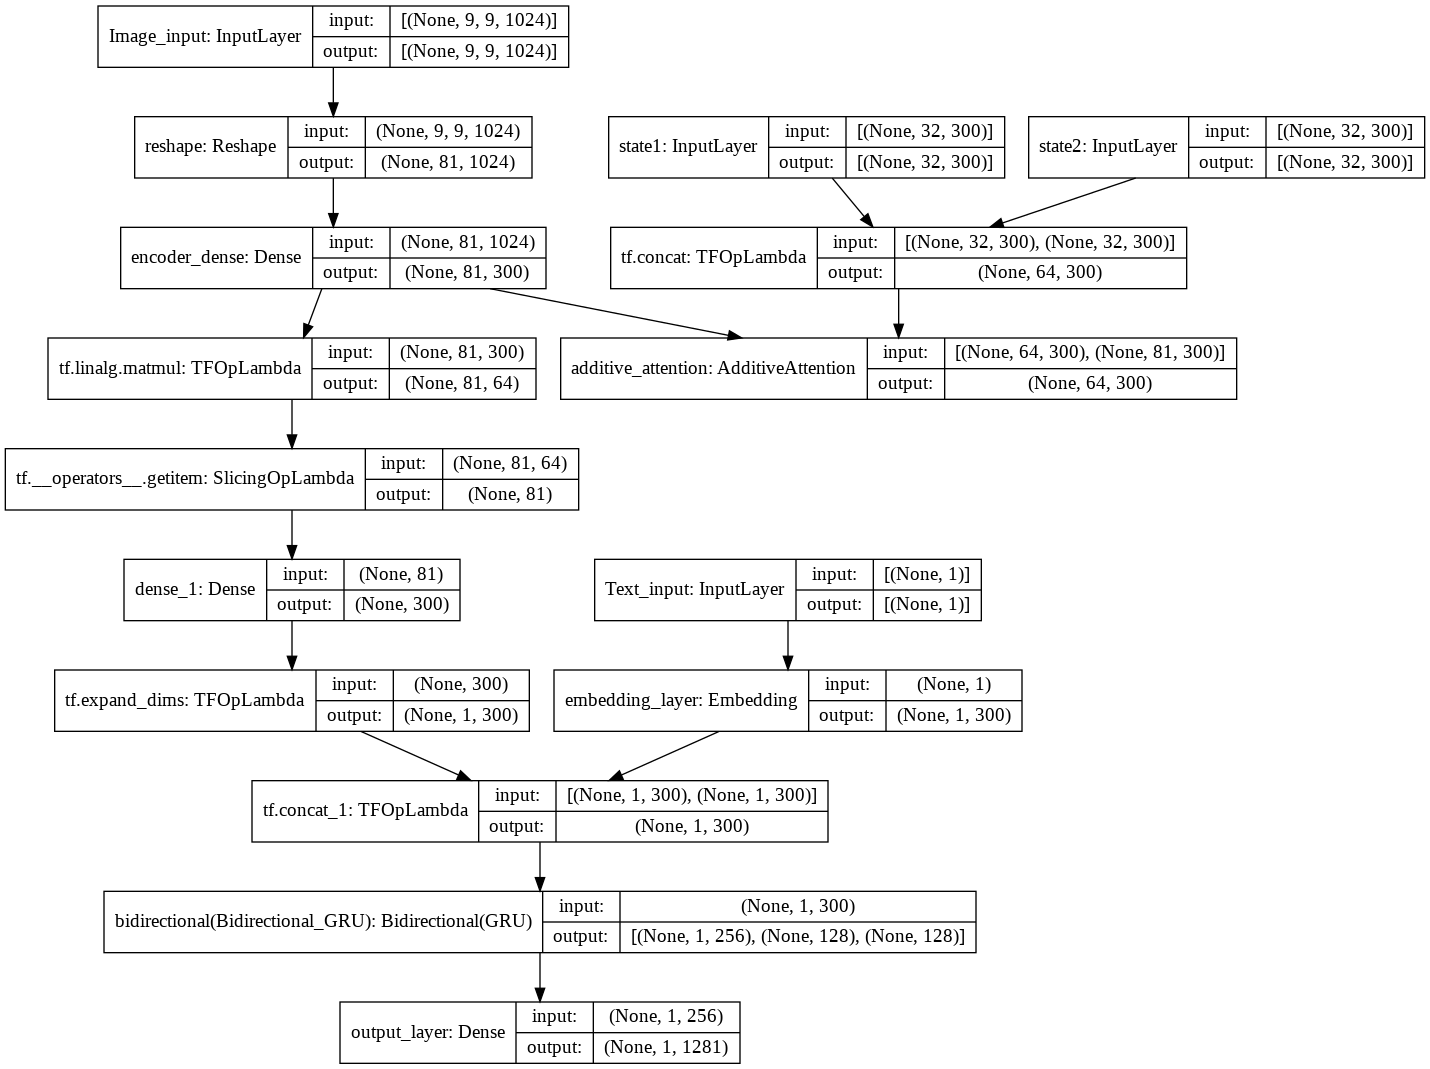

In [32]:
tf.keras.utils.plot_model(en_de, show_shapes = True)

In [ ]:
!rm -r logs/

In [34]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/' + current_time + '/train'
val_log_dir = 'logs/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()

        self.dense  = tf.keras.layers.Dense(embedding_dim)
        self.drop   = tf.keras.layers.Dropout(rate = 0.2)
        #https://stackoverflow.com/questions/49351038/how-to-reshape-the-tensor-in-keras
        self.reshape = keras.layers.core.Reshape((81, 1024))
    
    @tf.function
    def __call__(self, x):
  
        # x == image tensor shape (batch_size, 9, 9, 1024)

        x = self.reshape(x)

        x = self.dense(x)

        x = tf.nn.relu(x)

        # x after dense with embedding_dim and relu shape (batch_size, 81, embedding_dim)
      
        return x

In [37]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def __call__(self, features, hidden):
  

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    score = self.V(score)
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
  
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [38]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()

        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights = [embedding_matrix])

        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.units,return_sequences=True, return_state=True))
        
        self.dense_2 = tf.keras.layers.Dense(vocab_size, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))

        #Additive Attention
        self.attention = Attention(self.units)
        self.concat = tf.keras.layers.Concatenate()

    @tf.function
    def __call__(self, dec_input, encoder_output, forward_h, backward_h):
        
 
        embedding_output = self.embedding(dec_input)
        
        state = self.concat([forward_h , backward_h])
        
        context_vector, weights = self.attention(encoder_output, state)

        result = tf.concat([tf.expand_dims(context_vector, axis=1), embedding_output],axis=-1)

        lstm, forward_h, backward_h = self.gru(result, initial_state = [forward_h, backward_h])

        out = tf.reshape(lstm,(-1,lstm.shape[-1]))
        
        dense_op = self.dense_2(out)

        return dense_op, forward_h, backward_h, weights


In [39]:
# https://www.tensorflow.org/tutorials/text/image_captioning

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj = tf.keras.metrics.SparseCategoricalAccuracy()

def loss_func(real, pred):
    """Loss calculation"""
    loss_f = loss_obj(real, pred)
    return tf.reduce_mean(loss_f)


def acc_func(real, pred):
    """Accuracy calculation"""
    acc_f = acc_obj(real, pred)
    return tf.reduce_mean(acc_f)

In [40]:
embedding_dim = 300
units = 1000

encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

In [41]:
@tf.function
def train_step(tensor, target):

    loss    = 0
    train_acc = 0
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    forward =  tf.zeros((target.shape[0], units))
    backward =  tf.zeros((target.shape[0], units))
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):         
            predictions, forward, backward, _  = decoder(dec_input, features, forward, backward)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i],1)
       
    total_loss  = (loss / int(target.shape[1]))
    train_acc   = (train_acc / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss, train_acc

###################################################################################

#validation function

@tf.function
def val_step(tensor, target):
    loss_val = 0
    test_acc = 0
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    forward =  tf.zeros((target.shape[0], units))
    backward =  tf.zeros((target.shape[0], units))
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):
            predictions_val, forward, backward, _  = decoder(dec_input, features, forward, backward)
            loss_val += loss_func(target[:, i], predictions_val)
            test_acc += acc_func(target[:, i], predictions_val)
            dec_input = tf.expand_dims(target[:, i],1)
        
    total_loss_val = (loss_val / int(target.shape[1]))
    test_acc = (test_acc / int(target.shape[1]))


    return loss_val, total_loss_val, test_acc

In [42]:
tf.keras.backend.clear_session()
EPOCHS = 22
loss_plot_train = []
loss_plot_val = []

for epoch in (range(0, EPOCHS)):

    start = time.time()
    total_loss_train = 0
    total_loss_val  = 0
    train_acc = 0
    test_acc = 0

    for (batch, (img_tensor, target)) in enumerate(dataset_train):
        batch_loss, t_loss, acc = train_step(img_tensor, target)
        total_loss_train += t_loss    
        train_acc += acc
    
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', total_loss_train/ int(len(input_train) // BATCH_SIZE), step=epoch)
        tf.summary.scalar('accuracy', train_acc/ int(len(input_train) // BATCH_SIZE), step=epoch)

    loss_plot_train.append(total_loss_train / BATCH_SIZE )

    for (batch, (img_tensor, target)) in enumerate(dataset_val) :
        batch_loss, t_loss, acc1 = val_step(img_tensor, target)
        total_loss_val += t_loss
        test_acc += acc1

    with val_summary_writer.as_default():
        tf.summary.scalar('loss', total_loss_val / int(len(input_test) // BATCH_SIZE), step=epoch)
        tf.summary.scalar('accuracy', test_acc / int(len(input_test) // BATCH_SIZE), step=epoch)

    loss_plot_val.append(total_loss_val / BATCH_SIZE )

    print('Epoch {} Train Loss : {:.6f}   Test Loss : {:.6f}'.format(epoch + 1, (total_loss_train / int(len(input_train) // BATCH_SIZE)),
                                                                                 (total_loss_val / int(len(input_test) // BATCH_SIZE))))
    
    print('Epoch {} Train Acc  : {:.6f}   Test Acc  : {:.6f}'.format(epoch + 1, (train_acc / int(len(input_train) // BATCH_SIZE)), 
                                                                                 (test_acc / int(len(input_test) // BATCH_SIZE))))
    print('Time taken for epoch  {:.6f} sec\n'.format(time.time() - start))

Epoch 1 Train Loss : 0.897392   Test Loss : 0.550613
Epoch 1 Train Acc  : 0.843085   Test Acc  : 0.914602
Time taken for epoch  394.413059 sec

Epoch 2 Train Loss : 0.515022   Test Loss : 0.460538
Epoch 2 Train Acc  : 0.902030   Test Acc  : 0.925430
Time taken for epoch  41.156727 sec

Epoch 3 Train Loss : 0.449896   Test Loss : 0.414349
Epoch 3 Train Acc  : 0.909137   Test Acc  : 0.931574
Time taken for epoch  40.585761 sec

Epoch 4 Train Loss : 0.416592   Test Loss : 0.389460
Epoch 4 Train Acc  : 0.914129   Test Acc  : 0.935489
Time taken for epoch  40.762998 sec

Epoch 5 Train Loss : 0.392682   Test Loss : 0.371404
Epoch 5 Train Acc  : 0.917568   Test Acc  : 0.938576
Time taken for epoch  40.671159 sec

Epoch 6 Train Loss : 0.372646   Test Loss : 0.353652
Epoch 6 Train Acc  : 0.920137   Test Acc  : 0.940908
Time taken for epoch  41.314047 sec

Epoch 7 Train Loss : 0.355555   Test Loss : 0.343367
Epoch 7 Train Acc  : 0.922247   Test Acc  : 0.942873
Time taken for epoch  40.383418 sec

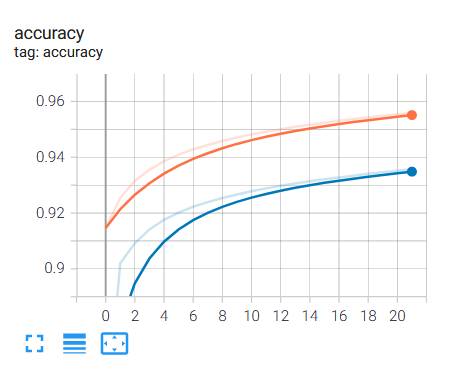

In [2]:
from IPython.display import Image
Image(filename = 'accuracy.png')

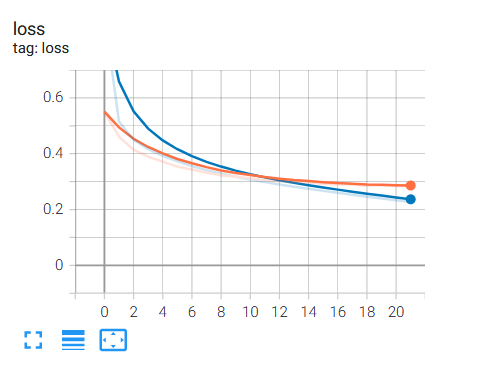

In [3]:
from IPython.display import Image
Image(filename = 'loss (2).png')

## Beam Search

In [46]:
# https://yashk2810.github.io/Image-Captioning-using-InceptionV3-and-Beam-Search/
# https://www.geeksforgeeks.org/sorted-function-python/

def calculate_score(x):
    """Calculates the cumulative score for the length of sentence"""
    return x[1]/len(x[0])

def beam_search(img_name, beam_index = 3):
    """Beam search implementaion takes images as input"""
    
    attention_shape = 81
    forward =  tf.zeros((1, units))
    backward =  tf.zeros((1, units))
    # call image concate function
    img_concate  = concate_image(img_name[0], img_name[1])
    # call preprocess funcation
    img_features = preprocess(img_concate)
    # call encoder model
    features_val = encoder(img_features)
    start = [tokenizer.word_index["<start>"]]
    dec_word = [[start, 0.0]]    
    attention_plot = np.zeros((max_len_output,  attention_shape))

    while len(dec_word[0][0]) < max_len_output:
        temp = []
        i = 0  
        for s in dec_word:
            # call decoder model
            predictions, forward, backward, attention_weights = decoder(tf.cast(tf.expand_dims([s[0][-1]], 0), tf.float32), features_val, forward, backward)
            word_preds = np.argsort(predictions[0])[-beam_index:]
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            i += 1
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += predictions[0][w]
                temp.append([next_cap, prob.numpy()])
        dec_word = temp

        dec_word = sorted(dec_word, reverse=False, key=calculate_score)
 
        dec_word = dec_word[-beam_index:]
    dec_word = dec_word[-1][0]
    impression = [tokenizer.index_word[i] for i in dec_word if i !=0]
    result = []
    
    for i in impression:
        if i != '<end>':
            result.append(i)
        else:
            break
    
    text = ' '.join(result[1:])

    return result, text, attention_plot

In [54]:
import matplotlib.image as mpimg

def test_img_cap_beam(img_data, actual_text, beam_indexing = 3):

    result, text, _ = beam_search(img_data, beam_index = beam_indexing)

    """Displays images for given input array of image names"""
    fig, axs = plt.subplots(1, len(img_data), figsize = (10,10), tight_layout=True)

    count = 0
    for img, subplot in zip(img_data, axs.flatten()):
        img_=  mpimg.imread('/content/drive/MyDrive/dl case study/NLMCXR_png/' + img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    reference = [actual_text.split()[1:-1]]
    result = result[1:]
    print("Beam Search, index=", beam_indexing)
    print("="*50)
    print("Actual", actual_text)
    print("Predicted:",text)
    print("="*50)
    print('Individual 1-gram: {:.4f} Cumulative 1-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(1, 0, 0, 0)), sentence_bleu(reference, result, weights=(1, 0, 0, 0))))
    print('Individual 2-gram: {:.4f} Cumulative 2-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 1, 0, 0)), sentence_bleu(reference, result, weights=(0.5, 0.5, 0, 0))))
    print('Individual 3-gram: {:.4f} Cumulative 3-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 1, 0)), sentence_bleu(reference, result, weights=(0.33, 0.33, 0.33, 0))))
    print('Individual 4-gram: {:.4f} Cumulative 4-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 0, 1)), sentence_bleu(reference, result, weights=(0.25, 0.25, 0.25, 0.25))))

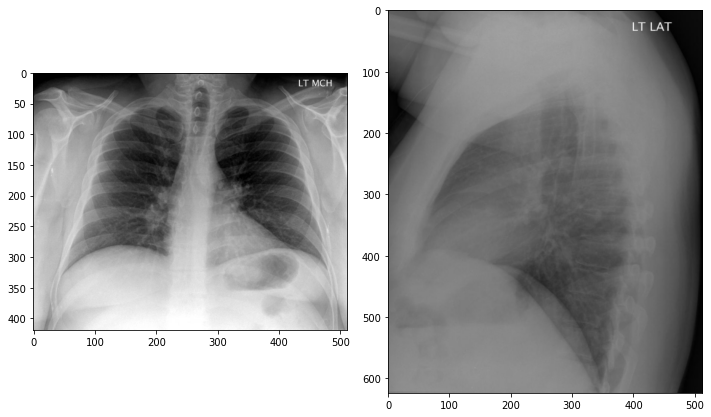

Beam Search, index= 3
Actual <start> no acute active cardiac pulmonary pleural disease <end>
Predicted: no acute cardiopulmonary abnormalities
Individual 1-gram: 0.2362 Cumulative 1-gram: 0.2362
Individual 2-gram: 0.1575 Cumulative 2-gram: 0.1928
Individual 3-gram: 0.4724 Cumulative 3-gram: 0.2615
Individual 4-gram: 0.4724 Cumulative 4-gram: 0.3018


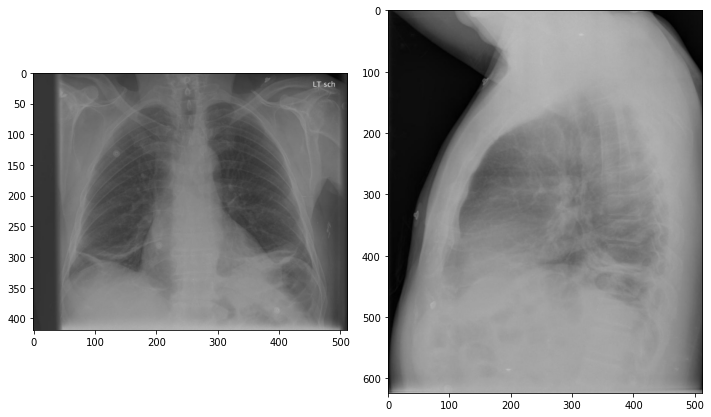

Beam Search, index= 3
Actual <start> improving lung volumes bibasilar atelectasis <end>
Predicted: no acute cardiopulmonary disease
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


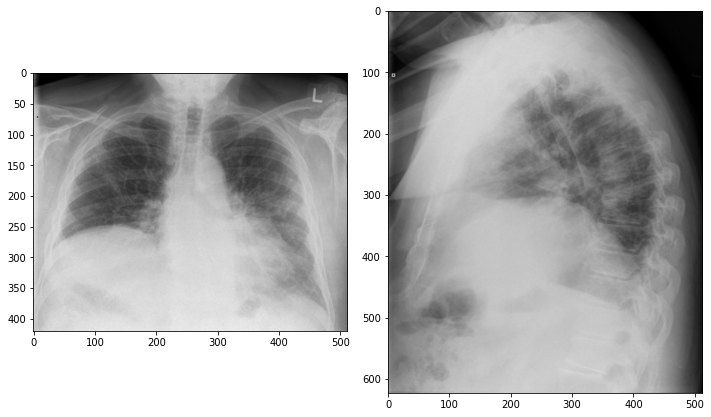

Beam Search, index= 3
Actual <start> stable appearing chest low lung volumes reticulonodular changes left lung base periphery left lung representing chronic inflammatory change also peripheral fibrotic appearing opacity periphery right upper lobe grossly stable no acute airspace consolidation stable mediastinal contour <end>
Predicted: heart size effusion
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


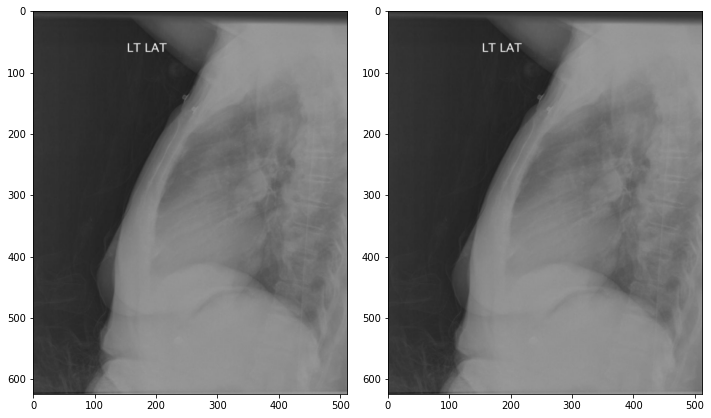

Beam Search, index= 3
Actual <start> no acute cardiopulmonary disease <end>
Predicted: heart size effusion
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


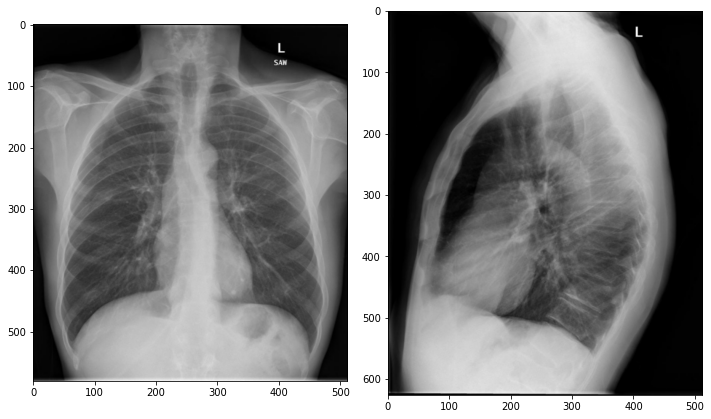

Beam Search, index= 3
Actual <start> one hyperexpanded lungs two otherwise normal chest <end>
Predicted: no acute cardiopulmonary process
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


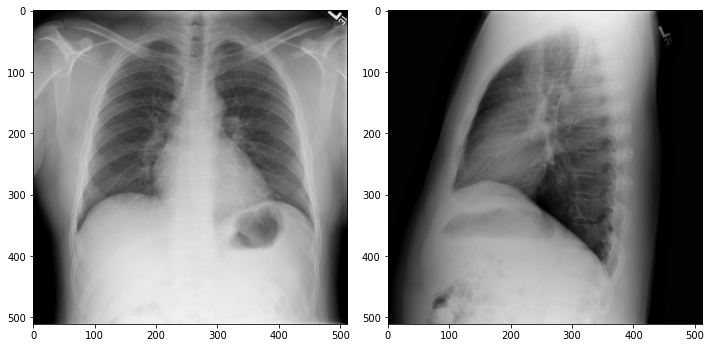

Beam Search, index= 3
Actual <start> prominent interstitial markings central lungs bases may secondary low lung volumes bronchovascular crowding differential considerations include interstitial infiltrates inflammatory infectious etiology mild pulmonary edema clinical correlation recommended <end>
Predicted: no acute cardiopulmonary process
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


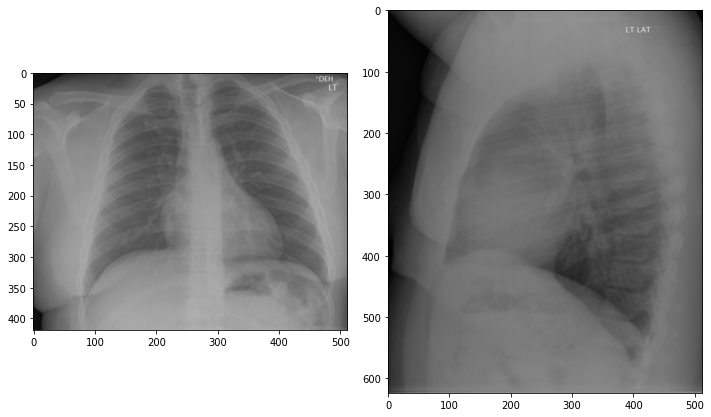

Beam Search, index= 3
Actual <start> one no acute intrathoracic abnormality <end>
Predicted: no acute cardiopulmonary disease
Individual 1-gram: 0.3894 Cumulative 1-gram: 0.3894
Individual 2-gram: 0.2596 Cumulative 2-gram: 0.3179
Individual 3-gram: 0.7788 Cumulative 3-gram: 0.4312
Individual 4-gram: 0.7788 Cumulative 4-gram: 0.4976


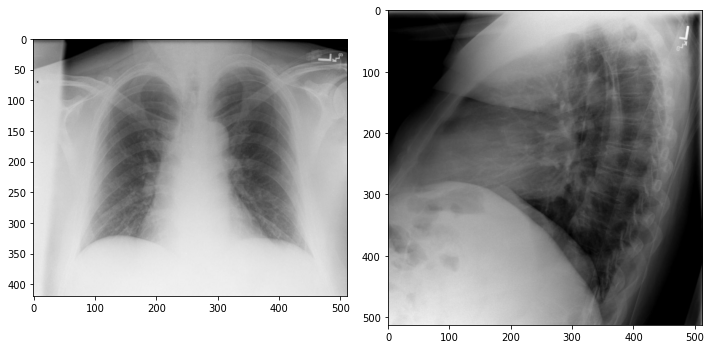

Beam Search, index= 3
Actual <start> low lung volumes otherwise no definite acute findings <end>
Predicted: no acute cardiopulmonary disease
Individual 1-gram: 0.1839 Cumulative 1-gram: 0.1839
Individual 2-gram: 0.3679 Cumulative 2-gram: 0.2601
Individual 3-gram: 0.3679 Cumulative 3-gram: 0.2927
Individual 4-gram: 0.3679 Cumulative 4-gram: 0.3093


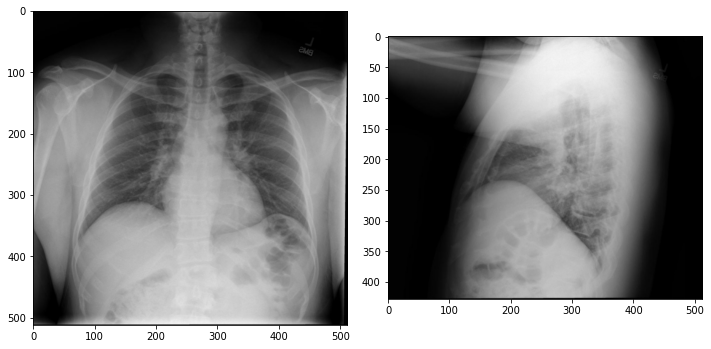

Beam Search, index= 3
Actual <start> no acute cardiopulmonary abnormality <end>
Predicted: heart size effusion
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


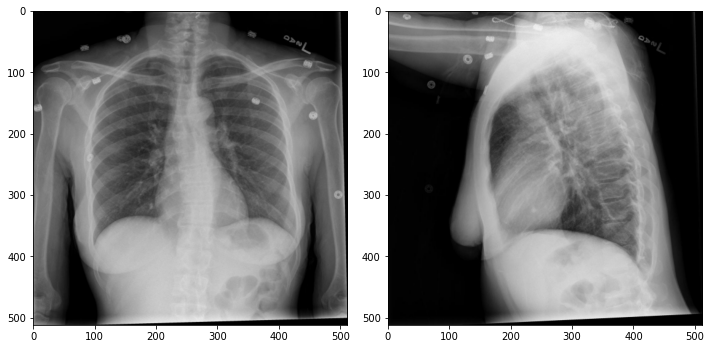

Beam Search, index= 3
Actual <start> one no acute cardiopulmonary disease <end>
Predicted: no acute cardiopulmonary process
Individual 1-gram: 0.5841 Cumulative 1-gram: 0.5841
Individual 2-gram: 0.5192 Cumulative 2-gram: 0.5507
Individual 3-gram: 0.3894 Cumulative 3-gram: 0.4929
Individual 4-gram: 0.7788 Cumulative 4-gram: 0.5507


In [55]:
for img, report in zip(input_test[20:30], output_test[20:30]):

    test_img_cap_beam(img, report, beam_indexing = 3)

## Greedy Search

In [56]:
def evaluate(image):
    
    attention_shape = 81
    attention_plot = np.zeros((max_len_output, attention_shape))
    forward =  tf.zeros((1, units))
    backward =  tf.zeros((1, units))
    img_concate  = concate_image(image[0], image[1])
    img_features = preprocess(img_concate)
    img_features = encoder(img_features)
    #img_features = tf.expand_dims(img_features, 0)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    text = " "
    #print(features_val.shape, dec_input.shape)
    for i in range(max_len_output):
        #print(img_features.shape, dec_input.shape, forward.shape, backward.shape)
        predictions, forward, backward, attention_weights = decoder(dec_input, img_features, forward, backward)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = np.argmax(predictions, axis=1).ravel()[0]

        result.append(tokenizer.index_word[predicted_id])
        text += " " + tokenizer.index_word[predicted_id]


        if tokenizer.index_word[predicted_id] == '<end>':
            return result, text, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
    
    attention_plot = attention_plot[:len(result), :]
    return result,  text, attention_plot

In [60]:
def test_img_cap(img_data, actual_text):

    result, text, _ = evaluate(img_data)

    """Displays images for given input array of image names"""
    fig, axs = plt.subplots(1, len(img_data), figsize = (10,10), tight_layout=True)

    count = 0
    for img, subplot in zip(img_data, axs.flatten()):
        img_= mpimg.imread('/content/drive/MyDrive/dl case study/NLMCXR_png/' + img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    reference = [actual_text.split()[1:-1]]
    result = result[:-1]
    print("="*50)
    print("Actual", actual_text)
    print("Predicted:",text)
    print("="*50)
    print('Individual 1-gram: {:.4f} Cumulative 1-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(1, 0, 0, 0)), sentence_bleu(reference, result, weights=(1, 0, 0, 0))))
    print('Individual 2-gram: {:.4f} Cumulative 2-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 1, 0, 0)), sentence_bleu(reference, result, weights=(0.5, 0.5, 0, 0))))
    print('Individual 3-gram: {:.4f} Cumulative 3-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 1, 0)), sentence_bleu(reference, result, weights=(0.33, 0.33, 0.33, 0))))
    print('Individual 4-gram: {:.4f} Cumulative 4-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 0, 1)), sentence_bleu(reference, result, weights=(0.25, 0.25, 0.25, 0.25))))

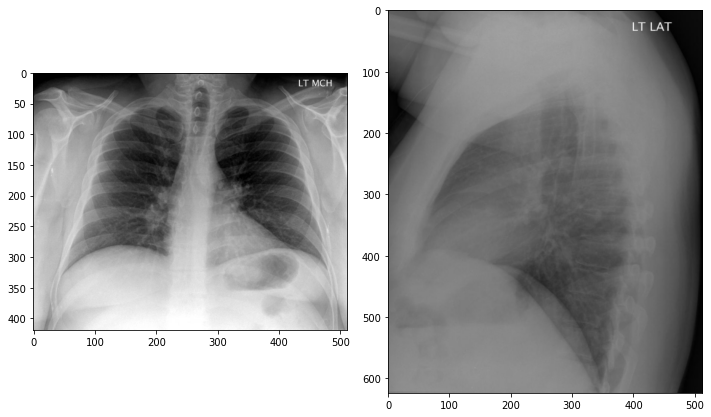

Actual <start> no acute active cardiac pulmonary pleural disease <end>
Predicted:   no acute cardiopulmonary abnormalities <end>
Individual 1-gram: 0.2362 Cumulative 1-gram: 0.2362
Individual 2-gram: 0.1575 Cumulative 2-gram: 0.1928
Individual 3-gram: 0.4724 Cumulative 3-gram: 0.2615
Individual 4-gram: 0.4724 Cumulative 4-gram: 0.3018


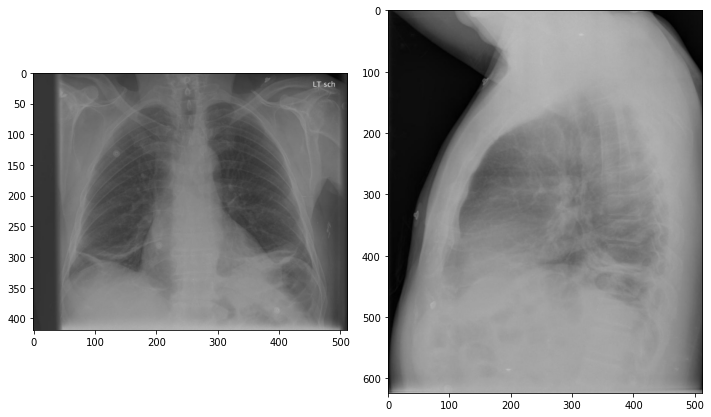

Actual <start> improving lung volumes bibasilar atelectasis <end>
Predicted:   no acute cardiopulmonary abnormality <end>
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


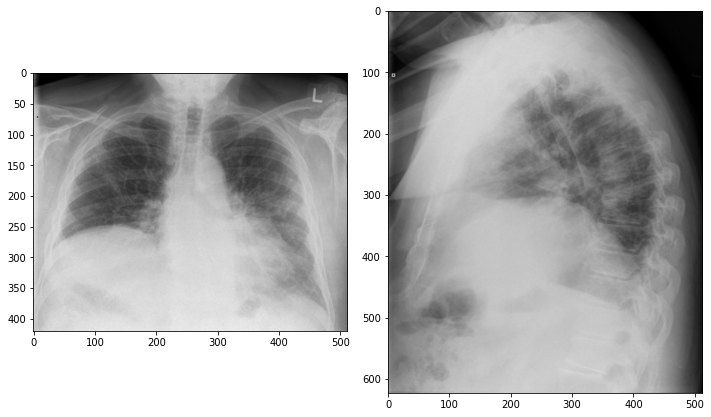

Actual <start> stable appearing chest low lung volumes reticulonodular changes left lung base periphery left lung representing chronic inflammatory change also peripheral fibrotic appearing opacity periphery right upper lobe grossly stable no acute airspace consolidation stable mediastinal contour <end>
Predicted:   no acute cardiopulmonary disease specifically no evidence infectioustuberculous pneumonia <end>
Individual 1-gram: 0.0111 Cumulative 1-gram: 0.0111
Individual 2-gram: 0.0062 Cumulative 2-gram: 0.0083
Individual 3-gram: 0.0498 Cumulative 3-gram: 0.0153
Individual 4-gram: 0.0498 Cumulative 4-gram: 0.0203


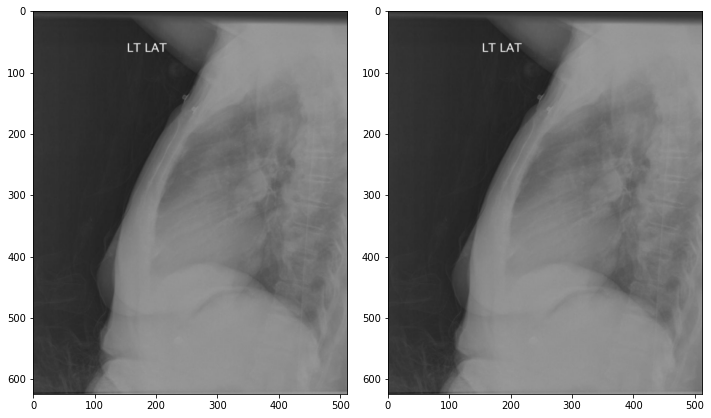

Actual <start> no acute cardiopulmonary disease <end>
Predicted:   no acute cardiopulmonary abnormality <end>
Individual 1-gram: 0.7500 Cumulative 1-gram: 0.7500
Individual 2-gram: 0.6667 Cumulative 2-gram: 0.7071
Individual 3-gram: 0.5000 Cumulative 3-gram: 0.6329
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.7071


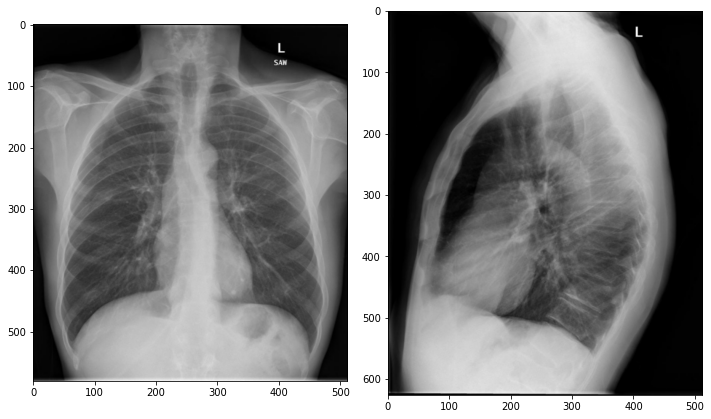

Actual <start> one hyperexpanded lungs two otherwise normal chest <end>
Predicted:   lumbar copd focal airspace disease two age one three soft structures seen upper heart appears normal mediastinal contour five lower limits no acute cardiopulmonary abnormalities <end>
Individual 1-gram: 0.1200 Cumulative 1-gram: 0.1200
Individual 2-gram: 1.0000 Cumulative 2-gram: 0.3464
Individual 3-gram: 1.0000 Cumulative 3-gram: 0.4967
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.5886


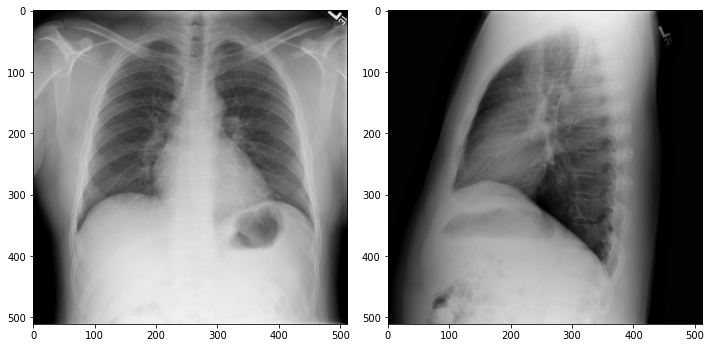

Actual <start> prominent interstitial markings central lungs bases may secondary low lung volumes bronchovascular crowding differential considerations include interstitial infiltrates inflammatory infectious etiology mild pulmonary edema clinical correlation recommended <end>
Predicted:   no acute cardiopulmonary findings <end>
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


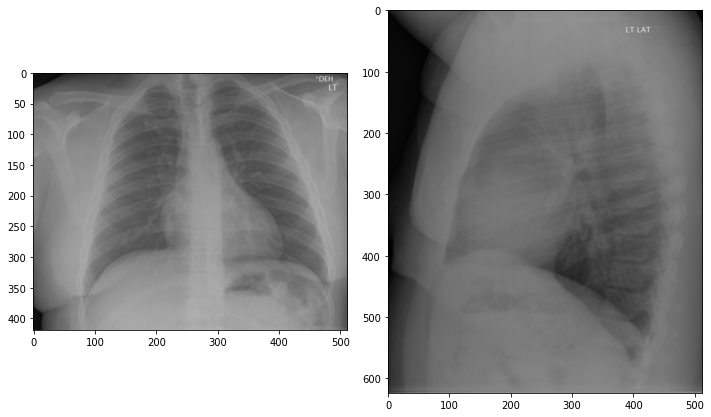

Actual <start> one no acute intrathoracic abnormality <end>
Predicted:   one no acute radiographic cardiopulmonary process <end>
Individual 1-gram: 0.5000 Cumulative 1-gram: 0.5000
Individual 2-gram: 0.4000 Cumulative 2-gram: 0.4472
Individual 3-gram: 0.2500 Cumulative 3-gram: 0.3721
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.4729


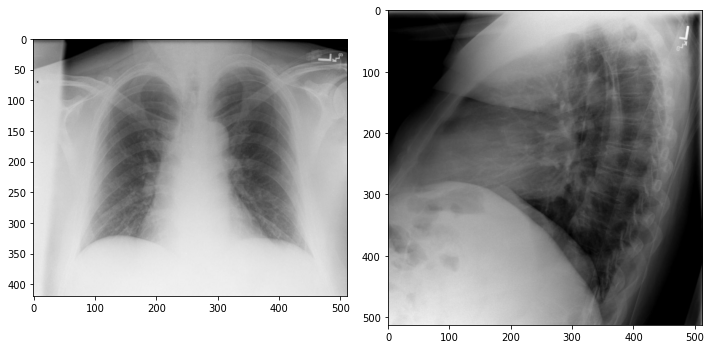

Actual <start> low lung volumes otherwise no definite acute findings <end>
Predicted:   no active disease <end>
Individual 1-gram: 0.0630 Cumulative 1-gram: 0.0630
Individual 2-gram: 0.1889 Cumulative 2-gram: 0.1090
Individual 3-gram: 0.1889 Cumulative 3-gram: 0.1314
Individual 4-gram: 0.1889 Cumulative 4-gram: 0.1435


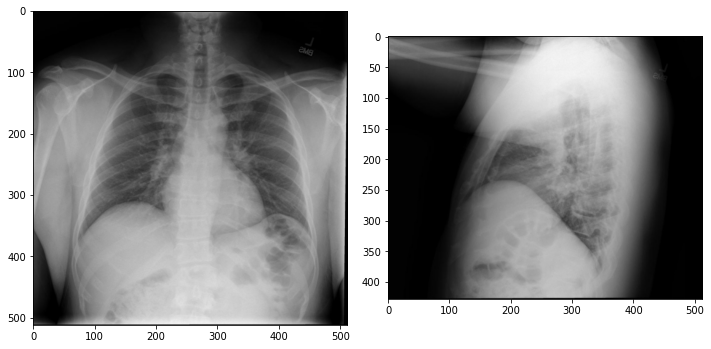

Actual <start> no acute cardiopulmonary abnormality <end>
Predicted:   multiple granulomatous disease without evidence tuberculosis <end>
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


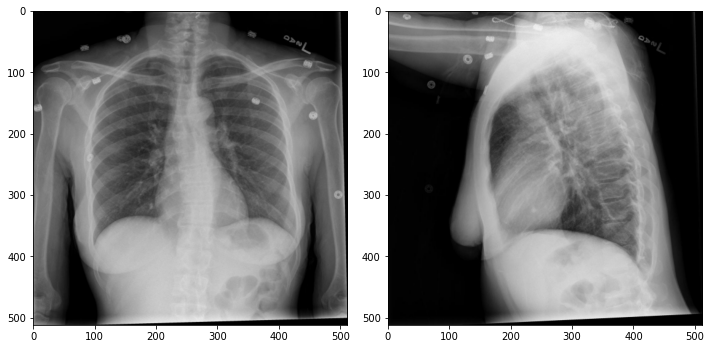

Actual <start> one no acute cardiopulmonary disease <end>
Predicted:   one no acute cardiopulmonary findings <end>
Individual 1-gram: 0.8000 Cumulative 1-gram: 0.8000
Individual 2-gram: 0.7500 Cumulative 2-gram: 0.7746
Individual 3-gram: 0.6667 Cumulative 3-gram: 0.7391
Individual 4-gram: 0.5000 Cumulative 4-gram: 0.6687


In [61]:
for img, report in zip(input_test[20:30], output_test[20:30]):
    test_img_cap(img, report)

## Attention Plot

In [62]:
def plot_attention(image, result, attention_plot):
    
    temp_image = np.array(image)

    fig = plt.figure(figsize=(12,12))

    len_result = len(result)
    for l in range(len_result):
        
        temp_att = np.resize(attention_plot[l], (25,25))
        ax = fig.add_subplot(len_result//2, 3, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Acutal text : <start> streaky right lower lobe infiltrate versus atelectasis <end>


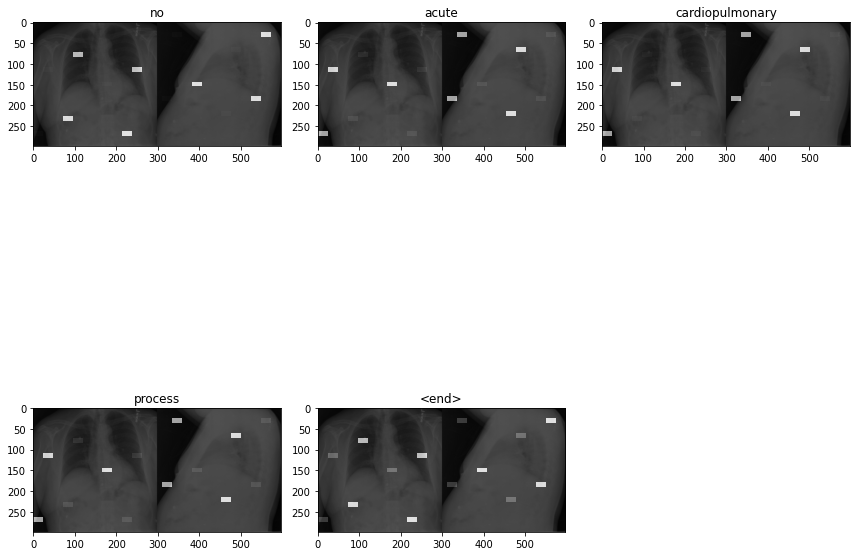

In [63]:
i,j = input_test[5], output_test[5]
print('Acutal text :', j)
result, text, attention_plot = evaluate(i)
i = concate_image(i[0], i[1])
plot_attention(i, result, attention_plot)

Acutal text : <start> no acute findings left mid lung subsegmental atelectasis <end>


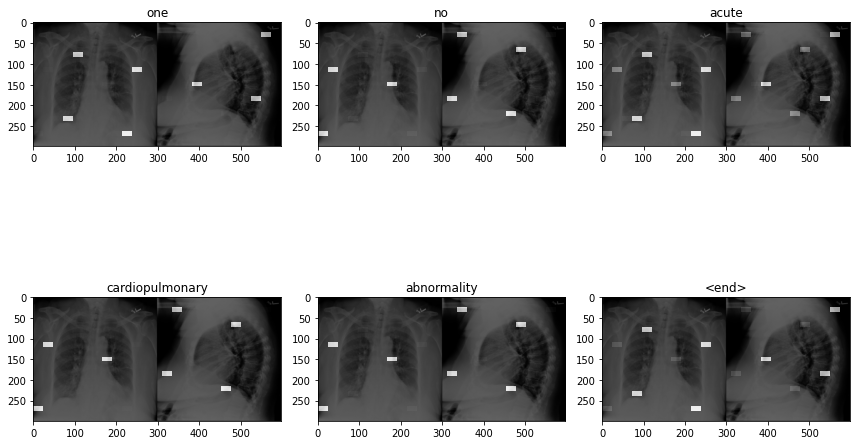

In [64]:
i,j = input_test[50], output_test[50]
print('Acutal text :', j)
result, text, attention_plot = evaluate(i)
i = concate_image(i[0], i[1])
plot_attention(i, result, attention_plot)

Acutal text : <start> no acute cardiopulmonary abnormality <end>


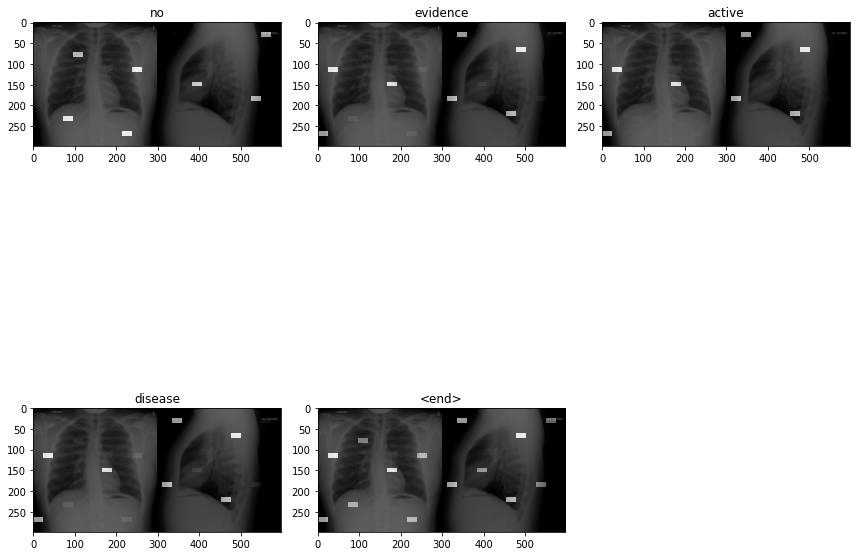

In [69]:
i,j = input_test[500], output_test[500]
print('Acutal text :', j)
result, text, attention_plot = evaluate(i)
i = concate_image(i[0], i[1])
plot_attention(i, result, attention_plot)

## Bleu Score

In [66]:
def prediction(image):
  
    forward =  tf.zeros((1, units))
    backward =  tf.zeros((1, units))
    img_features = encoder(image)
    #img_features = tf.expand_dims(img_features, 0)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    text = " "
    #print(features_val.shape, dec_input.shape)
    for i in range(max_len_output):
        #print(features_val.shape, dec_input.shape, hidden.shape)
        predictions, forward, backward, _ = decoder(dec_input, img_features, forward, backward)
    
        predicted_id = np.argmax(predictions, axis=1).ravel()[0]

        result.append(tokenizer.index_word[predicted_id])
        text += " " + tokenizer.index_word[predicted_id]

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, text

        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result,  text

In [67]:
# predict sentence for bleu score of train data
g =  [ ]
for img, report in  tqdm(zip(tensor_train, output_train)) :a
    result, text = prediction(img)
    g.append(result) 

In [68]:
# predict sentence for bleu score of test data
gg =  [ ]
for img in tqdm(tensor_test) :
    result, text = prediction(img)
    gg.append(result) 

In [1]:
# computer bleu score of train data
s = 0
for reference, candidate in (zip(output_train, g)) :

    reference = [reference.split()[1:-1]]
    candidate = candidate[:-1]
    #print(reference, candidate)
    s += sentence_bleu(reference, candidate,  weights=(0.25,0.25,0.25,0.25))
    #break

print('Actual  :', reference)
print('Candidat :', candidate[:-1])
print('Bleu Score of Train Data :- ', s / len(g))

Actual  : [['no', 'acute', 'cardiopulmonary', 'disease']]
Candidat : ['no', 'acute', 'cardiopulmonary', 'disease']
Bleu Score of Train Data :-  41.77758685555


In [3]:
# computer bleu score of test data
ss = 0
for reference, candidate in (zip(output_test, gg)) :

    reference = [reference.split()[1:-1]]
    candidate = candidate[:-1]
    #print(reference, candidate)
    ss += sentence_bleu(reference, candidate,  weights=(0.25,0.25,0.25,0.25))
    
print('Actual  :', reference)
print('Candidat :', candidate[:-1])
print('Bleu Score of Test Data :- ', ss / len(gg))0

Actual  : [['no', 'acute', 'cardiopulmonary', 'findings']]
Candidat : ['low', 'lung', 'volumes', 'otherwise', 'no', 'definite', 'acute', 'findings']
Bleu Score of Test Data :-  39.15486556844


## Observation :-

* This model gave good result as compare to basic model, in the prediction not any words repeated.


* Use bi-direction GRU, our model performance and bleu score are improved.


* We used beam search + attention model.

## Limitation :-

* Still some predict sentence are meaning less.


* Also most frequent words are appearing like 'no acute cardiopulmonary abnormality'.


* Beam search method not well perform as compare to greedy seach method.

# Future work :-


* We will use bert model for this task instead of attetion mechanism.


* We will try large amount data then we get good perfomance in model.